In [0]:
#!!pip uninstall tensorflow
#!pip install tensorflow==2.1.0

In [11]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
PROJECT_DIR = "/content/gdrive/My Drive/Colab Notebooks/"
DATA_FILE_NAME = 'Input.xlsx'
CLEANSED_FILE_NAME = 'Data/cleansed_data.csv'

In [13]:
#import basic libraies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
#nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
pd.set_option('display.max_colwidth', 0)

##**1. Data Loading**

In [15]:
data_df = pd.read_excel("/content/gdrive/My Drive/Colab Notebooks/Input.xlsx", lines=True)
data_df.head(20)

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager name)\r\n-checked the user name in ad and reset the password.\r\n-advised the user to login and check.\r\n-caller confirmed that he was able to login.\r\n-issue resolved.,spxjnwir pjlcoqds,GRP_0
1,outlook,"\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail.com\r\n\r\nhello team,\r\n\r\nmy meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?\r\n\r\nkind",hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail.com\r\n\r\nhi\r\n\r\ni cannot log on to vpn\r\n\r\nbest,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0
6,event: critical:HostName_221.company.com the value of mountpoint threshold for /oracle/SID_37/erpdata21/,"event: critical:HostName_221.company.com the value of mountpoint threshold for /oracle/SID_37/erpdata21/sr3psa1d_7/sr3psa1d.data7,perpsr3psa1d,4524 is 98",jyoqwxhz clhxsoqy,GRP_1
7,ticket_no1550391- employment status - new non-employee [enter user's name],ticket_no1550391- employment status - new non-employee [enter user's name],eqzibjhw ymebpoih,GRP_0
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0
9,ticket update on inplant_874773,ticket update on inplant_874773,fumkcsji sarmtlhy,GRP_0


In [16]:
data_df.shape

(8500, 4)

In [17]:
data_df.describe()

,Short description,Description,Caller,Assignment group
count,8492,8499,8500,8500
unique,7481,7817,2950,74
top,password reset,the,bpctwhsn kzqsbmtp,GRP_0
freq,38,56,810,3976


In [18]:
data_df[data_df.Description.isnull()]

,Short description,Description,Caller,Assignment group
4395,i am locked out of skype,NaN,viyglzfo ajtfzpkb,GRP_0


In [0]:
#Replace space in column names with '_' and to lower case for better naming conversion
data_df.columns = [c.replace(' ', '_') for c in data_df.columns]
data_df.columns = [c.lower() for c in data_df.columns]

Inference:
1. There are total of 8500 datasets spread across 4 dimensions.
2. As we are classifing the ticket to category based on description, caller column is of no information to us. This can be removed in the pre-processing.
3. Though there are short description & description, we will classify based on description as it provides more details on the isssue.
4. From describe count, we can notice that there are some missing values in the descriptions columnns.
5. There is 1 missing value in the description which can be replaced with short description of the same.
6. There are 74 unique categories to which the tickets are classified to.
7. There seems to be lot of cleanup required in the description column.

  a. There are os related new line and line termination tags.

  b. Few description have header - received from : - which doesn't provide much information on classification.

  c. Few description also have footer note - Thanks/regards follwed by name - which doesn't provide much information on classification.
  
  d. There are few encoded words in description which could be name of the persons that are encrypted owing to PII governance which needs to be handled in pre-processing.
  
  e. There are also few system drive path, software versioning number and ip addresses.

  f. Some description might have attached with evidence photos which resulted in cid: tages in the description footer.







## **2. Exploratory Data Anlysis :**

### **2.1 Pre-Requestic**

In [0]:
#create a working copyy from the original dataframe
desc_df = data_df.copy(deep=True)

#Drop caller as it is not utilized in problem classification
desc_df = desc_df.drop(['caller'], axis=1)

In [21]:
#check for null/NaN inn the description
desc_df[desc_df.description.isnull()]

,short_description,description,assignment_group
4395,i am locked out of skype,NaN,GRP_0


In [0]:
#Replace empty description with that short description
desc_df.description.fillna(desc_df.short_description, inplace=True)

In [23]:
#recheck for null/NaN in description
desc_df[desc_df.description.isnull()]

,short_description,description,assignment_group


In [24]:
desc_df.head(5)

,short_description,description,assignment_group
0,login issue,-verified user details.(employee# & manager name)\r\n-checked the user name in ad and reset the password.\r\n-advised the user to login and check.\r\n-caller confirmed that he was able to login.\r\n-issue resolved.,GRP_0
1,outlook,"\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail.com\r\n\r\nhello team,\r\n\r\nmy meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?\r\n\r\nkind",GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail.com\r\n\r\nhi\r\n\r\ni cannot log on to vpn\r\n\r\nbest,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,GRP_0
4,skype error,skype error,GRP_0


### **2.2 Target Category Analysis**

In [0]:
##category_df.index = description_df.index
#category_df = pd.DataFrame(data = description_df.copy('assignment_group'), columns=['category'])
#category_df = description_df.assignment_group.value_counts()
#category_df.head()

In [0]:
#labelencoder = LabelEncoder()
#data_df['cate_assignment_group'] = labelencoder.fit_transform(data_df['assignment_group'])

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.,
        4500.]), <a list of 10 Text major ticklabel objects>)

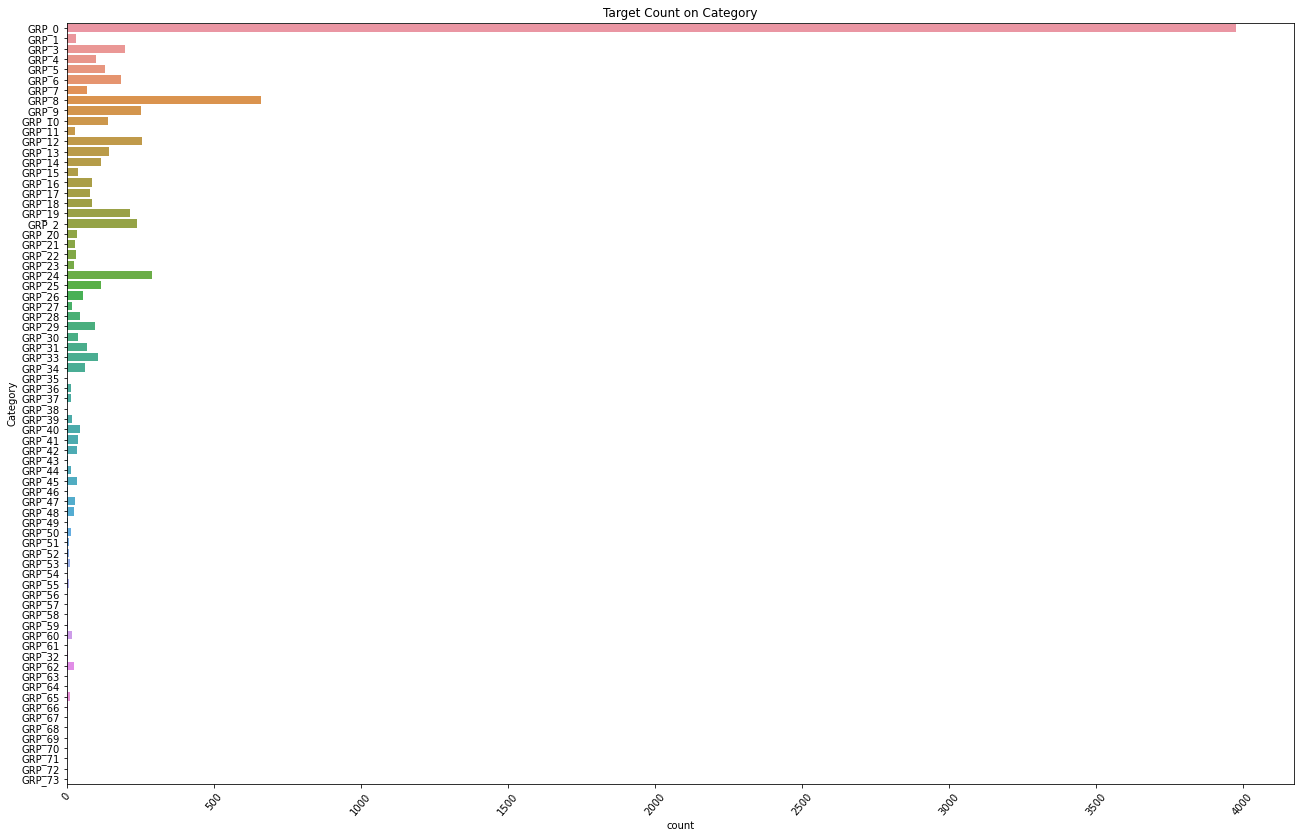

In [27]:
plt.figure(figsize=(22, 14))
sns.countplot(y=desc_df["assignment_group"])
plt.ylabel('Category')
plt.title('Target Count on Category')
plt.xticks(rotation=50)

Inference:

### **2.3 Feature Analysis:**

#### **2.3.1 Basic Analysis**

In [0]:
#create a working copy of data set
working_desc_df = desc_df.copy(deep=True)

In [0]:
working_desc_df = working_desc_df.drop(['short_description', 'assignment_group'], axis=1)

In [30]:
working_desc_df.head(10)

,description
0,-verified user details.(employee# & manager name)\r\n-checked the user name in ad and reset the password.\r\n-advised the user to login and check.\r\n-caller confirmed that he was able to login.\r\n-issue resolved.
1,"\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail.com\r\n\r\nhello team,\r\n\r\nmy meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?\r\n\r\nkind"
2,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail.com\r\n\r\nhi\r\n\r\ni cannot log on to vpn\r\n\r\nbest
3,unable to access hr_tool page
4,skype error
5,unable to log in to engineering tool and skype
6,"event: critical:HostName_221.company.com the value of mountpoint threshold for /oracle/SID_37/erpdata21/sr3psa1d_7/sr3psa1d.data7,perpsr3psa1d,4524 is 98"
7,ticket_no1550391- employment status - new non-employee [enter user's name]
8,unable to disable add ins on outlook
9,ticket update on inplant_874773


In [0]:
#to get words and their count in the dataset
def tokenize_counter(data):
  words_bow_series = data.str.split(expand=True).unstack().value_counts()
  words_bow_df = pd.DataFrame({'words':words_bow_series.index, 'count':words_bow_series.values})
  return words_bow_df;

In [0]:
#bar plot for word cound plotting
def word_count_plot(xData, yData, numofwords, sort = 'asc'):
  if sort == 'asc':
    start = 0
    end = numofwords
  else:
    end = len(description_bow['count'])
    start = end - numofwords

  trace = sns.barplot(
      y=yData.iloc[start:end],
      x=xData.iloc[start:end])
  return trace

In [0]:
#word cloud implementation to understannd word importance and frequency
from wordcloud import WordCloud
def generate_wordcloud(corpus, stopwords='', mask=None, max_words=100, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=24, image_color=False, ):
  desc_words = ' '
  #combine all text in the corpus into string of words
  for line in corpus:
   desc_words = desc_words + line + ' '

  wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    #max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=600,collocations = False,
                    mask = mask).generate(str(desc_words))
  return wordcloud

#### **2.3.2 Before Cleaning**

In [34]:
desc_bow_df = tokenize_counter(working_desc_df['description'])
print('Length of tokens : ', len(desc_bow_df))

Length of tokens :  30115


In [35]:
desc_wordcloud = generate_wordcloud(working_desc_df['description'])
len(desc_wordcloud.words_)

200

(-0.5, 799.5, 599.5, -0.5)

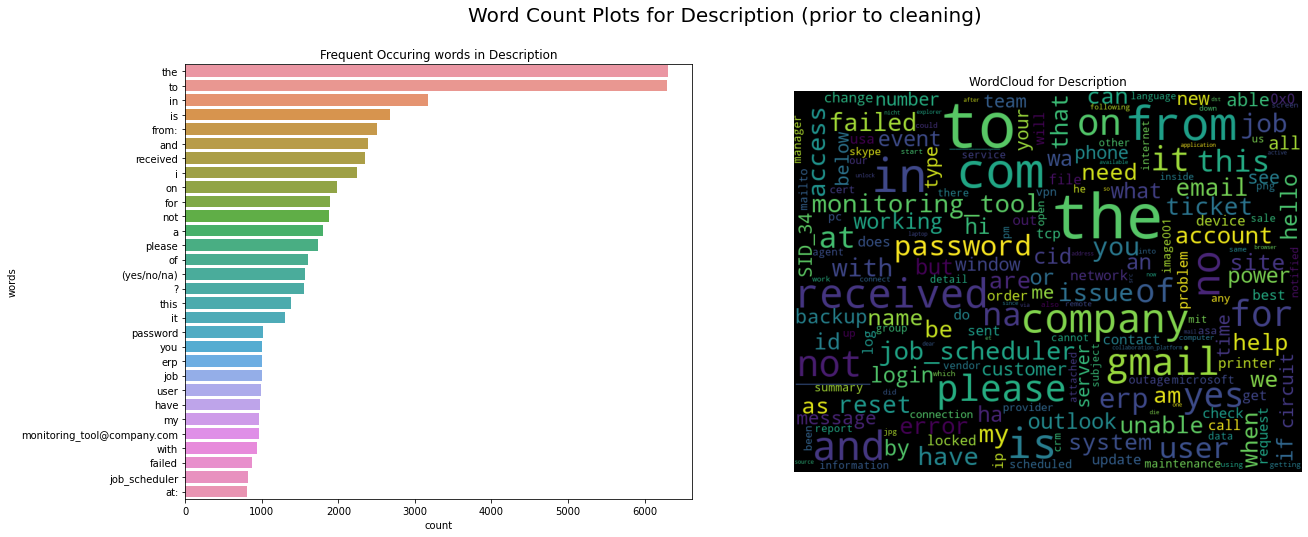

In [36]:
plt.figure(figsize=(20, 8))
plt.suptitle('Word Count Plots for Description (prior to cleaning)',fontsize=20)
plt.subplot(1, 2, 1)
plt.title('Frequent Occuring words in Description')
word_count_plot(desc_bow_df['count'], desc_bow_df['words'], 30, 'asc')
plt.subplot(1, 2, 2)
plt.title('WordCloud for Description')
plt.imshow(desc_wordcloud)
plt.axis("off")

Combine above steps into single method defination for re-use.

In [0]:
#method to plot frequency & wordcloud
def plot_count_cloud_graph(wordcount, wordcloud, title):
  plt.figure(figsize=(20, 8))
  plt.suptitle(title,fontsize=20)
  plt.subplot(1, 2, 1)
  plt.title('Frequent Occuring words in Description')
  word_count_plot(wordcount['count'], wordcount['words'], 30, 'asc')
  plt.subplot(1, 2, 2)
  plt.title('WordCloud for Description')
  plt.imshow(desc_wordcloud)
  plt.axis("off")

In [0]:
#method to generate bow & wordcloud
def generate_bow_wordcloud(text):
  bow_df = tokenize_counter(text)
  wordcloud = generate_wordcloud(text)
  return bow_df, wordcloud

Vocabulary Size : 30115 



,description
0,-verified user details.(employee# & manager name)\r\n-checked the user name in ad and reset the password.\r\n-advised the user to login and check.\r\n-caller confirmed that he was able to login.\r\n-issue resolved.
1,"\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail.com\r\n\r\nhello team,\r\n\r\nmy meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?\r\n\r\nkind"
2,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail.com\r\n\r\nhi\r\n\r\ni cannot log on to vpn\r\n\r\nbest
3,unable to access hr_tool page
4,skype error


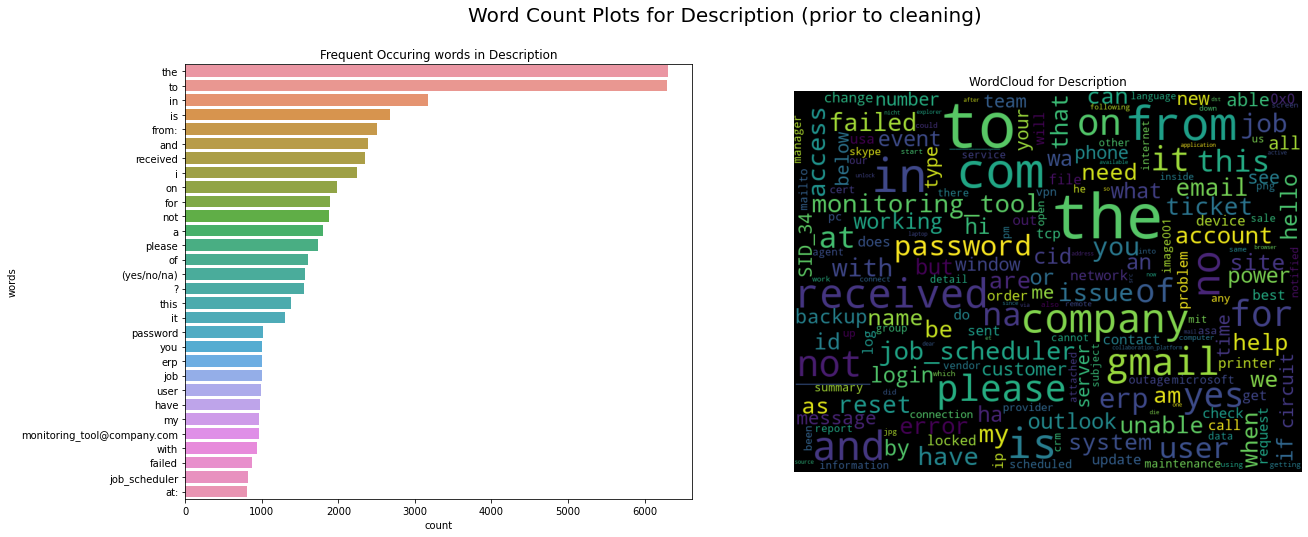

In [39]:
desc_bow_df, desc_wordcloud = generate_bow_wordcloud(working_desc_df['description'])
#to print vocal size from Bag Of Words created
print('Vocabulary Size : {} \n'.format(len(desc_bow_df)))
#plot the frequency $ cloud plot
plot_count_cloud_graph(desc_bow_df, desc_wordcloud, 'Word Count Plots for Description (prior to cleaning)')
#print top 5 description
working_desc_df.head()


Inference:
1. Notice too many common words like - the, to, in, is - exists.
2. Notice the existance of special characeters - ?, monitoring_tool@company.com - the dataset

Lets do carry some pre processing on the data to clean up

#### **2.3.3 Data Cleaning Analysis**

Pre-Processing
1. Remove excape characters - new line
2. Remove received from header & footer tags
2. Remove the image attachment reference in footer
4. Remove any email id reference
4. Remove Punctuation
6. Remove stop words
7. Check frequent words with respect to problem context


In [0]:
#remove os line break tags
def remove_line_break(text):
  text = str(text)
  data = text.replace('\r\n', '\n')
  data = data.replace('\r', '\n')
  return data

In [0]:
#remove some header and footers in the descriptionn
def remove_exclusion_text(text, exclusionText, line_breaker):
  data = [line for line in text.split(line_breaker) if not exclusionText in line]
  return ' '.join(data)

In [0]:
def clean_text(text, exclusionTagList):
  data = remove_line_break(text)
  #print(data)
  for excl_txt in exclusionTagList:
    data = remove_exclusion_text(data, excl_txt, '\n')
  return data

In [0]:
#word starting with following tags can be excluded as they dont difine problem statement
exclusion_text_tags = ['received from', 'cid:image', 'importance:', 
                       'email:','subject:','to:', 'sent:', 'from:', 
                       'approved by', ' user id :','name :','mailto:']

In [0]:
working_desc_df['cleansed_desc'] = working_desc_df['description'].apply(lambda text : clean_text(text, exclusion_text_tags))

Vocabulary Size : 20048 



0    -verified user details.(employee# & manager name) -checked the user name in ad and reset the password. -advised the user to login and check. -caller confirmed that he was able to login. -issue resolved.
1       hello team,  my meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?  kind                                                            
2       hi  i cannot log on to vpn  best                                                                                                                                                                       
3    unable to access hr_tool page                                                                                                                                                                             
4    skype error                                                                                                                                                        

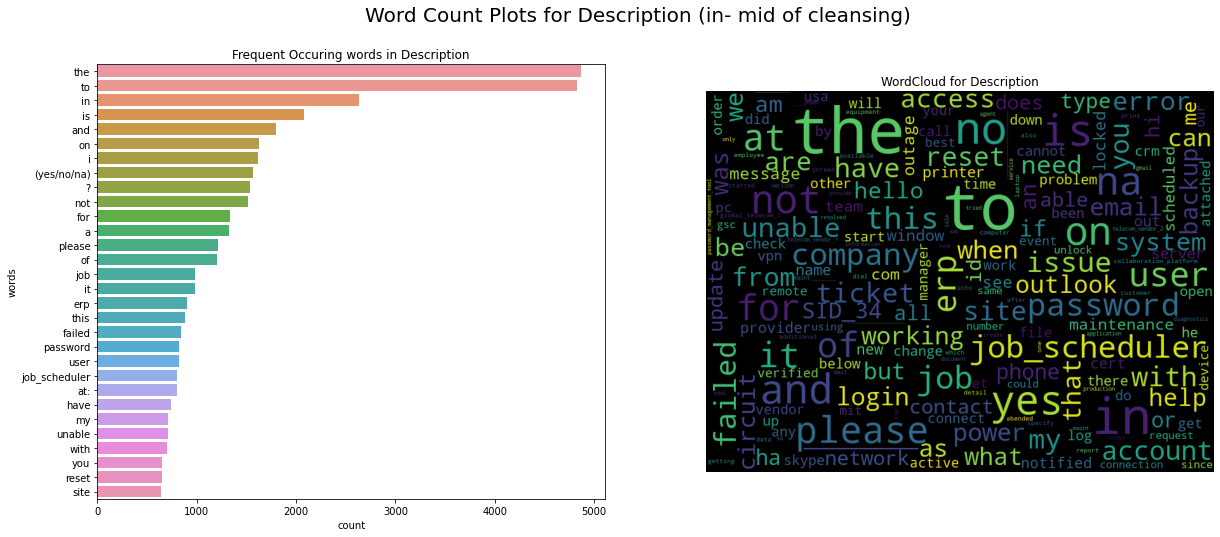

In [45]:
desc_bow_df, desc_wordcloud = generate_bow_wordcloud(working_desc_df['cleansed_desc'])
#to print vocal size from Bag Of Words created
print('Vocabulary Size : {} \n'.format(len(desc_bow_df)))
#plot the frequency $ cloud plot
plot_count_cloud_graph(desc_bow_df, desc_wordcloud, 'Word Count Plots for Description (in- mid of cleansing)')
#print top 5 description
working_desc_df['cleansed_desc'].head()


In [0]:
#method to convert text to lowercase
def to_lower (text):
  return text.lower()

In [0]:
#remove some header and footers in the descriptionn
import re
def remove_email(text):
  re_mail = re.compile('\S+@+\S+.?')
  data = [re_mail.sub(' ', word) for word in text.split()]
  return ' '.join(data)

In [0]:
def remove_underscore(text):
    text = text.replace('_',' ')
    text = text.replace("'",'')
    return text

In [0]:
#replace punctutions with white space
def remove_punctuation(text):
    return text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))

In [0]:
def clean_text(text, exclusionTagList):
  data = remove_line_break(text)
  for excl_txt in exclusionTagList:
    data = remove_exclusion_text(data, excl_txt, '\n')
  data = to_lower(data)
  data = remove_email(data)
  data = remove_underscore(data)
  data = remove_punctuation(data)
  return data

In [0]:
working_desc_df['cleansed_desc'] = working_desc_df['description'].apply(lambda text : clean_text(text, exclusion_text_tags))

Vocabulary Size : 13180 



0     verified user details  employee    manager name   checked the user name in ad and reset the password   advised the user to login and check   caller confirmed that he was able to login   issue resolved 
1    hello team  my meetings skype meetings etc are not appearing in my outlook calendar  can somebody please advise how to correct this  kind                                                                 
2    hi i cannot log on to vpn best                                                                                                                                                                            
3    unable to access hr tool page                                                                                                                                                                             
4    skype error                                                                                                                                                        

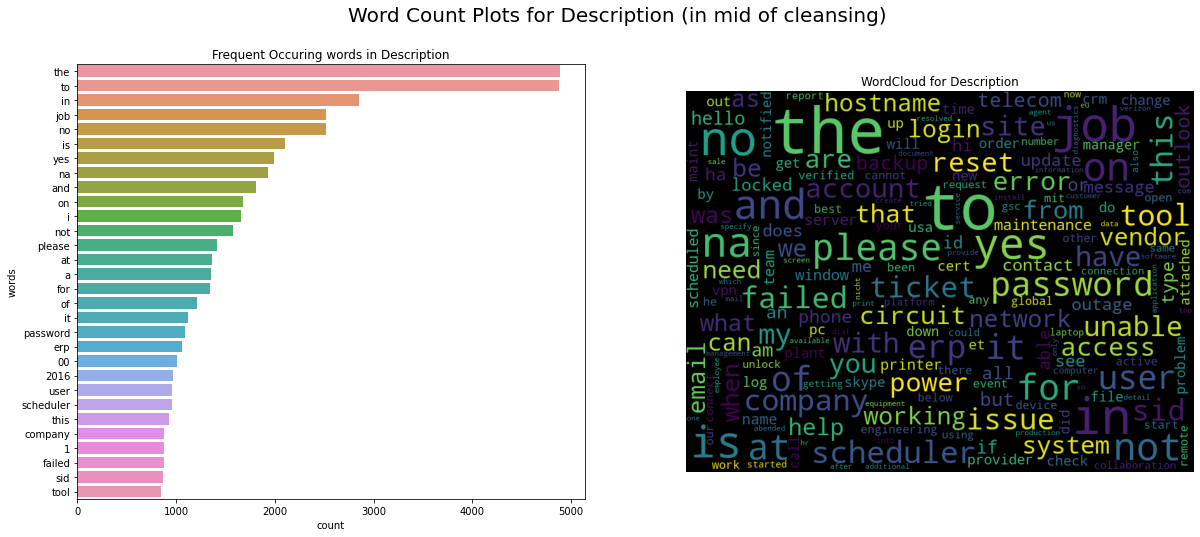

In [52]:
desc_bow_df, desc_wordcloud = generate_bow_wordcloud(working_desc_df['cleansed_desc'])
#to print vocal size from Bag Of Words created
print('Vocabulary Size : {} \n'.format(len(desc_bow_df)))
#plot the frequency $ cloud plot
plot_count_cloud_graph(desc_bow_df, desc_wordcloud, 'Word Count Plots for Description (in mid of cleansing)')
#print top 5 description
working_desc_df['cleansed_desc'].head()


In [0]:
#strip more than 1 leading or trailing white spaces
def strip_addl_whitespace(text):
    return " ".join([word for word in text.split() if word.strip()])

In [0]:
# remove any numbers in the dataset
def remove_non_alpha(text):
  return " ".join([word for word in text.split(" ") if word.isalpha()])

In [0]:
def clean_text(text, exclusionTagList):
  data = remove_line_break(text)
  #print(data)
  for excl_txt in exclusionTagList:
    data = remove_exclusion_text(data, excl_txt, '\n')
  data = to_lower(data)
  data = remove_email(data)
  data = remove_underscore(data)
  data = remove_punctuation(data)
  data = strip_addl_whitespace(data)
  data = remove_non_alpha(data)
  return data

In [0]:
working_desc_df['cleansed_desc'] = working_desc_df['description'].apply(lambda text : clean_text(text, exclusion_text_tags))

Vocabulary Size : 9311 



0    verified user details employee manager name checked the user name in ad and reset the password advised the user to login and check caller confirmed that he was able to login issue resolved
1    hello team my meetings skype meetings etc are not appearing in my outlook calendar can somebody please advise how to correct this kind                                                      
2    hi i cannot log on to vpn best                                                                                                                                                              
3    unable to access hr tool page                                                                                                                                                               
4    skype error                                                                                                                                                                                 
Name: cleansed_desc, dtype: ob

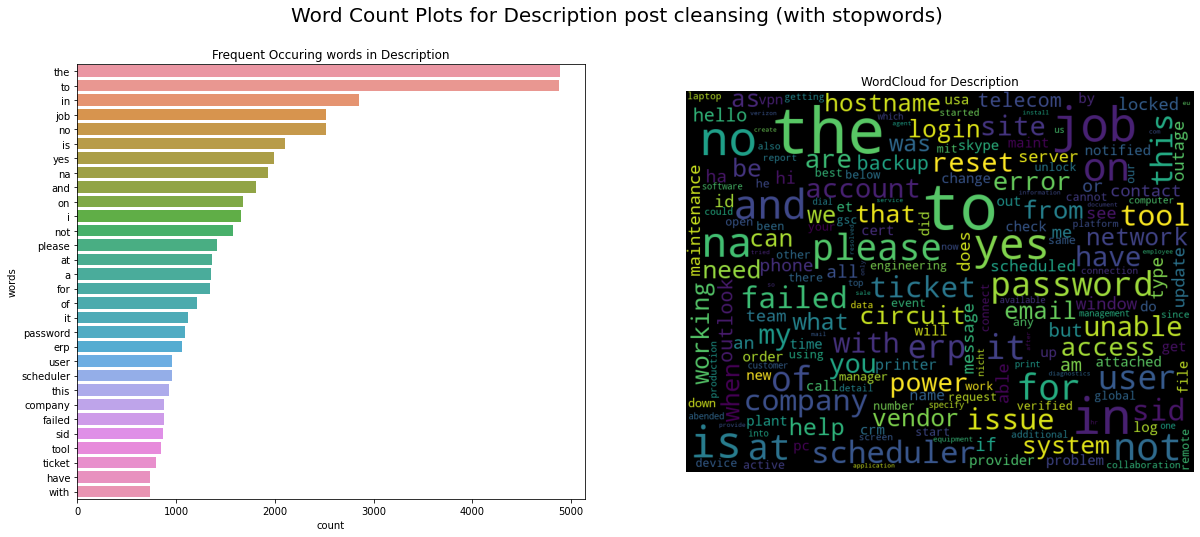

In [57]:
desc_bow_df, desc_wordcloud = generate_bow_wordcloud(working_desc_df['cleansed_desc'])
#to print vocal size from Bag Of Words created
print('Vocabulary Size : {} \n'.format(len(desc_bow_df)))
#plot the frequency $ cloud plot
plot_count_cloud_graph(desc_bow_df, desc_wordcloud, 'Word Count Plots for Description post cleansing (with stopwords)')
#print top 5 description
working_desc_df['cleansed_desc'].head()


Stop Words:

In [58]:
#fetch stopwods from nltk lib
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
#method to exclude the stopwords from the corpura and also generate exclude word cout
from collections import Counter
from collections import OrderedDict

removed_words=[]
def remove_stopwords(text, stopwords):
  global removed_words
  #global removed_words_counter 
  global removed_words_df
  data = []
  for word in text.split():
    if not word in stopwords:
      data.append(word)
    else:
      removed_words.append(word)
  removed_words_counter = Counter(removed_words)
  removed_words_counter = OrderedDict(sorted(removed_words_counter.items(), key = lambda x: x[1], reverse=True))
  removed_words_df = pd.DataFrame(removed_words_counter.items(),columns=['words','count'])
  return ' '.join(data)

In [0]:
def clean_text(text, exclusionTagList, stop_words=None):
  data = str(text)
  data = remove_line_break(data)
  for excl_txt in exclusionTagList:
    data = remove_exclusion_text(data, excl_txt, '\n')
  data = to_lower(data)
  data = remove_email(data)
  data = remove_underscore(data)
  data = remove_punctuation(data)
  data = strip_addl_whitespace(data)
  data = remove_non_alpha(data)
  data = remove_stopwords(data, stop_words)
  return data

In [0]:
working_desc_df['cleansed_desc'] = working_desc_df['description'].apply(lambda text : clean_text(text, exclusion_text_tags, stop_words))

Vocabulary Size :  9183


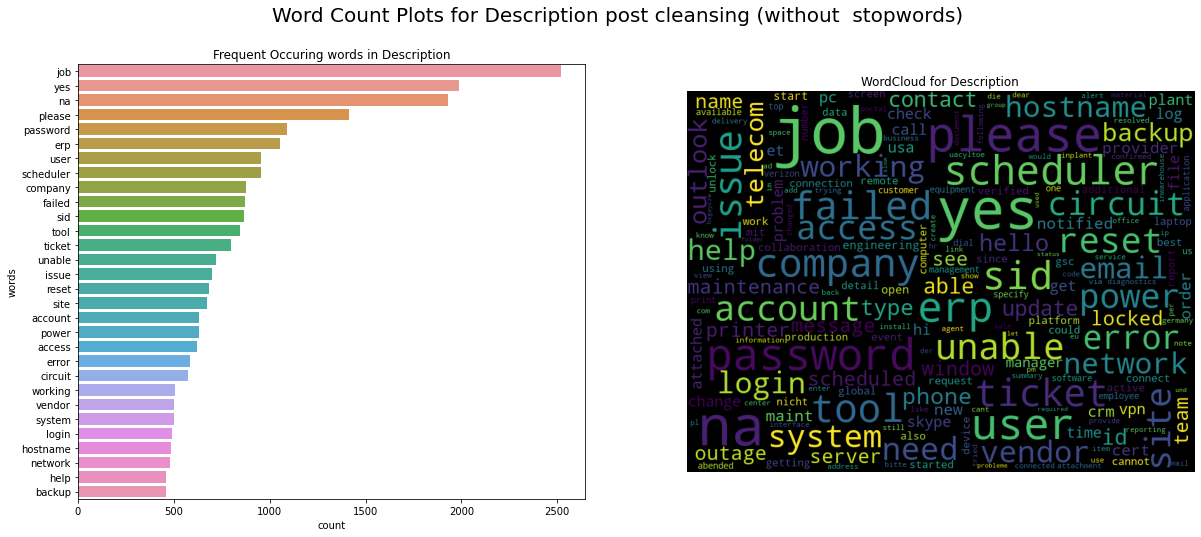

In [62]:
desc_bow_df, desc_wordcloud = generate_bow_wordcloud(working_desc_df['cleansed_desc'])
print('Vocabulary Size : ', len(desc_bow_df))
plot_count_cloud_graph(desc_bow_df, desc_wordcloud, 'Word Count Plots for Description post cleansing (without  stopwords)')

Lets explore the removed words

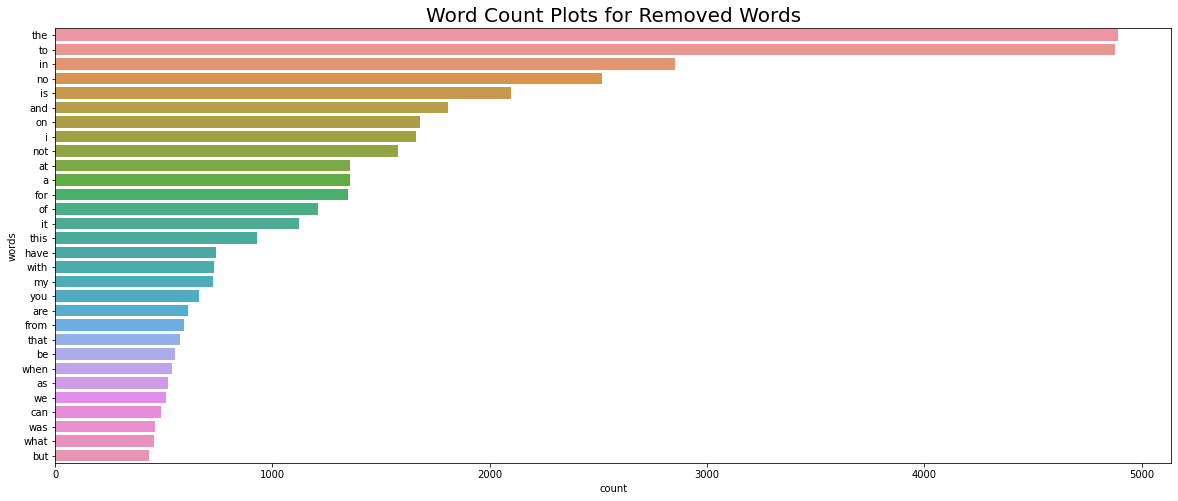

In [63]:
plt.figure(figsize=(20, 8))
plt.title('Word Count Plots for Removed Words',fontsize=20)
word_count_plot(removed_words_df['count'],removed_words_df['words'], 30, 'asc')

In [0]:
addl_stopwords = ['yes', 'please', 'hello', 'name','yes','best','kind']
not_stopwords = ['not', 'no', 'nor']

In [0]:
#to add addl stop words to the nltk list
stop_words.extend(addl_stopwords)
#remove non stopwords from NLTK stopwords list
stop_words = [word for word in stop_words if word not in not_stopwords]

In [0]:
working_desc_df['cleansed_desc'] = working_desc_df['description'].apply(lambda text : clean_text(text, exclusion_text_tags, stop_words))

Vocabulary Size :  9180


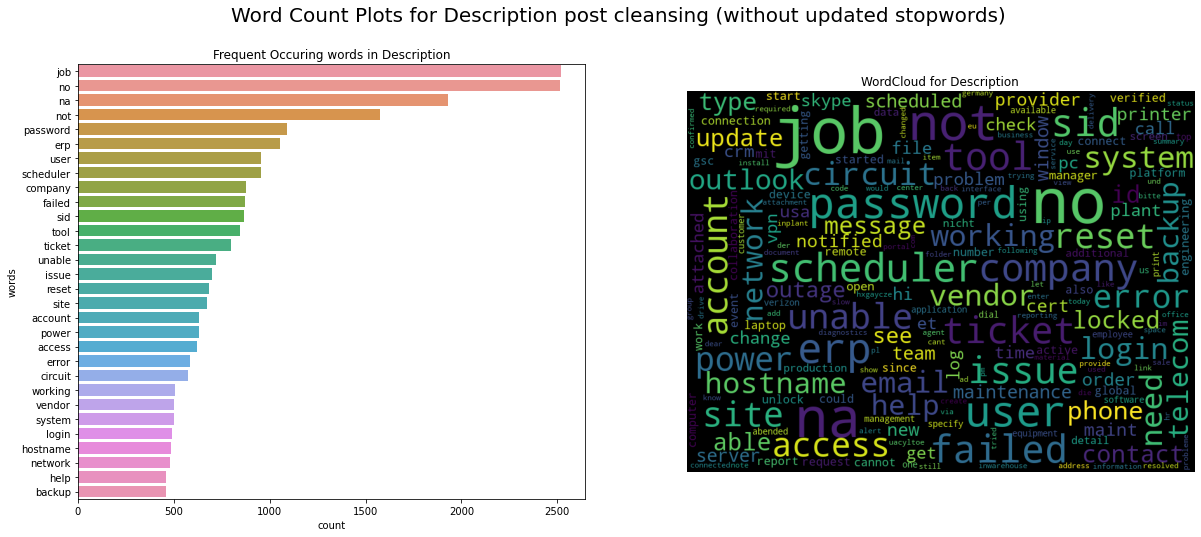

In [67]:
desc_bow_df, desc_wordcloud = generate_bow_wordcloud(working_desc_df['cleansed_desc'])
print('Vocabulary Size : ', len(desc_bow_df))
plot_count_cloud_graph(desc_bow_df, desc_wordcloud, 'Word Count Plots for Description post cleansing (without updated stopwords)')

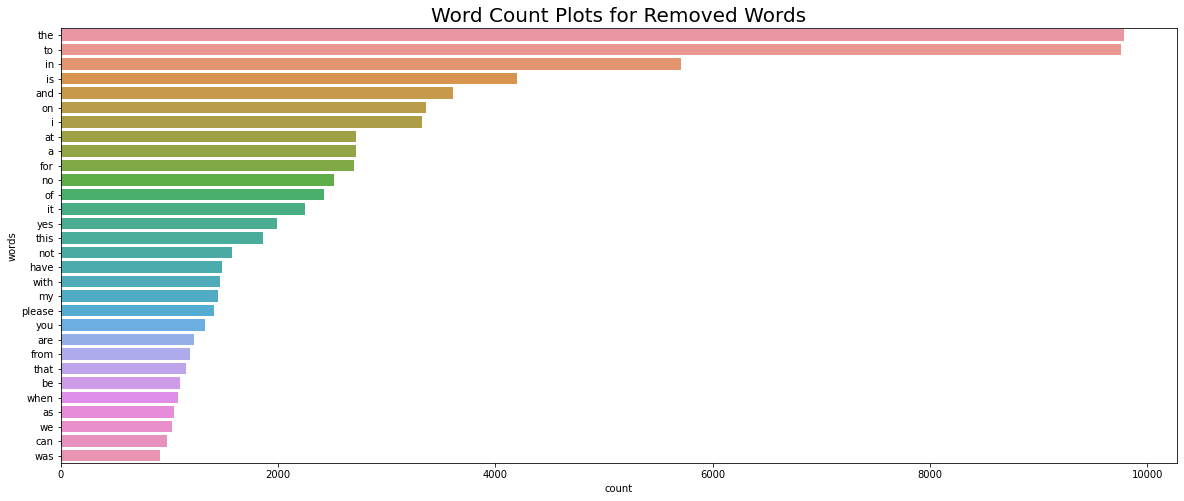

In [68]:
plt.figure(figsize=(20, 8))
plt.title('Word Count Plots for Removed Words',fontsize=20)
word_count_plot(removed_words_df['count'],removed_words_df['words'], 30, 'asc')

### **2.3.4 n-gram Analysis**

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

#method to create the n-gram from the corpus along with frequency of occurance
def get_top_n_ngram(corpus, ngram_range = (1,1), top=None):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    ngram_df = pd.DataFrame(words_freq[:top], columns = ['n-gram_words' , 'count'])
    return ngram_df

In [0]:
working_desc_df['cleansed_desc'] = working_desc_df['description'].apply(lambda text : clean_text(text, exclusion_text_tags,[]))
working_desc_df['cleansed_desc_wo_stopwords'] = working_desc_df['description'].apply(lambda text : clean_text(text, exclusion_text_tags, stop_words))

In [0]:
unigram_df = get_top_n_ngram(working_desc_df['cleansed_desc'],(1,1), 20)
unigram_df_wo_stopwords = get_top_n_ngram(working_desc_df['cleansed_desc_wo_stopwords'],(1,1), 20)

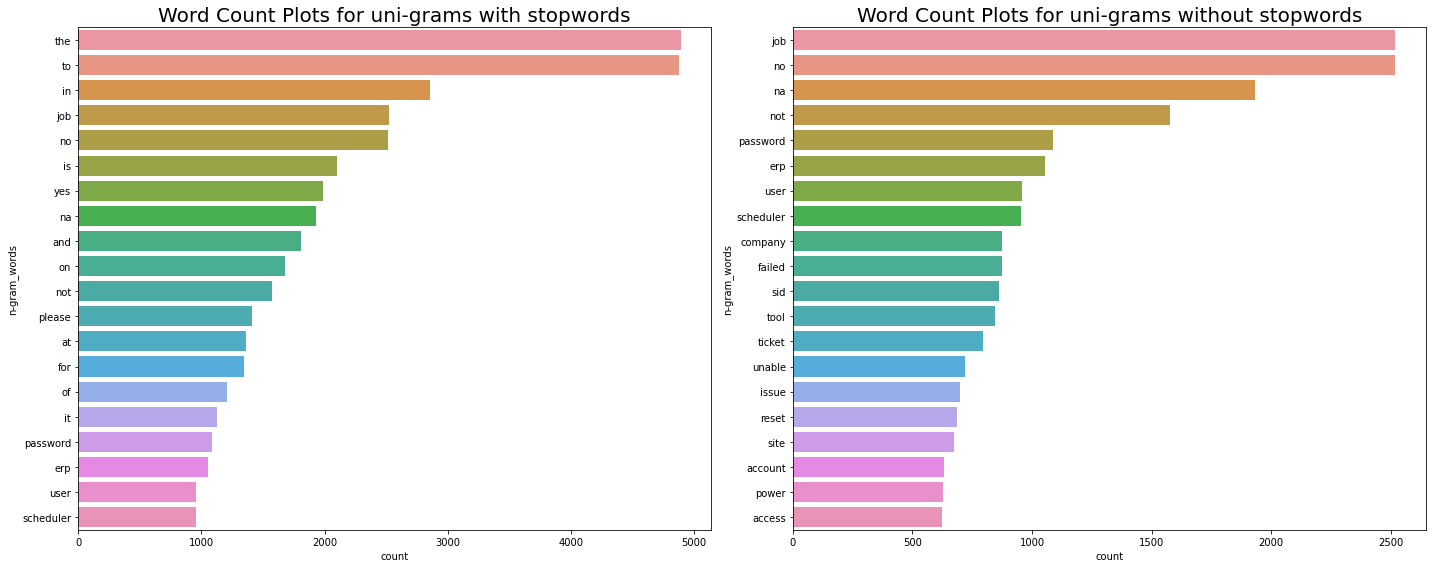

In [72]:
plt.figure(figsize=(20, 8))
#plt.suptitle('Word Count Plots for uni-grams',fontsize=20)
plt.subplot(1, 2, 1)
plt.title('Word Count Plots for uni-grams with stopwords',fontsize=20)
word_count_plot(unigram_df['count'],unigram_df['n-gram_words'], 30, 'asc')
plt.subplot(1, 2, 2)
plt.title('Word Count Plots for uni-grams without stopwords',fontsize=20)
word_count_plot(unigram_df_wo_stopwords['count'],unigram_df_wo_stopwords['n-gram_words'], 30, 'asc')
plt.tight_layout()

In [0]:
bigram_df = get_top_n_ngram(working_desc_df['cleansed_desc'],(2,2), 20)
bigram_df_wo_stopwords = get_top_n_ngram(working_desc_df['cleansed_desc_wo_stopwords'],(2,2), 20)

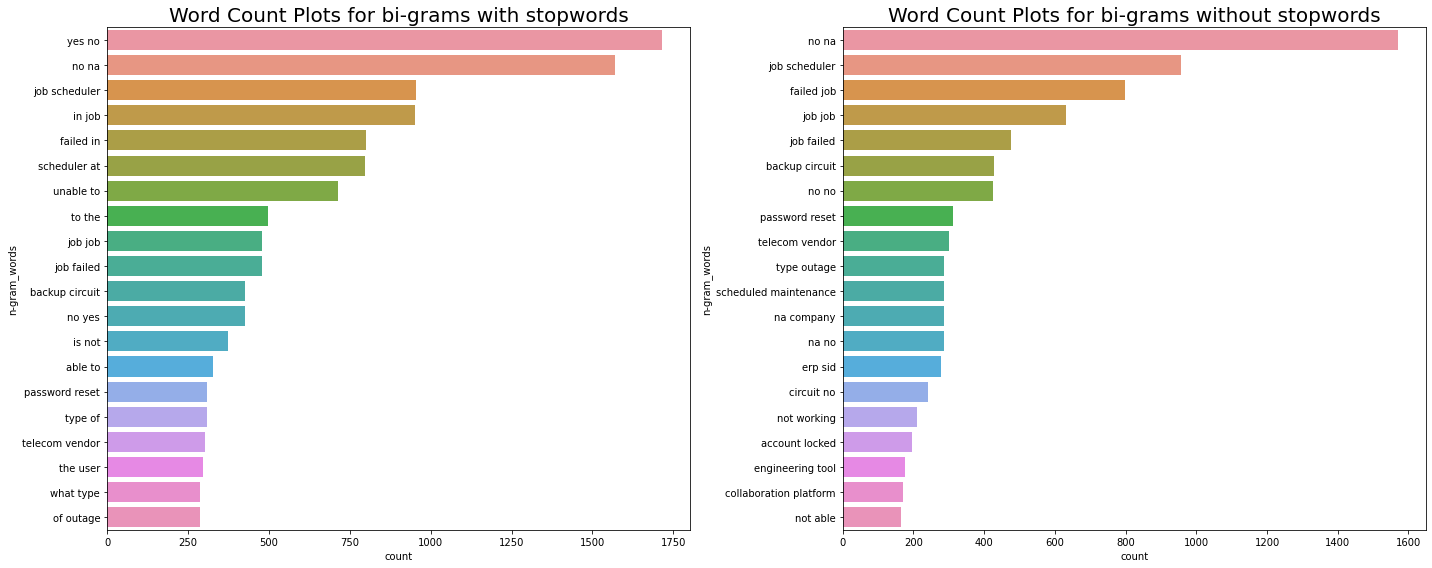

In [74]:
plt.figure(figsize=(20, 8))
#plt.suptitle('Word Count Plots for uni-grams',fontsize=20)
plt.subplot(1, 2, 1)
plt.title('Word Count Plots for bi-grams with stopwords',fontsize=20)
word_count_plot(bigram_df['count'],bigram_df['n-gram_words'], 30, 'asc')
plt.subplot(1, 2, 2)
plt.title('Word Count Plots for bi-grams without stopwords',fontsize=20)
word_count_plot(bigram_df_wo_stopwords['count'],bigram_df_wo_stopwords['n-gram_words'], 30, 'asc')
plt.tight_layout()

In [0]:
trigram_df = get_top_n_ngram(working_desc_df['cleansed_desc'],(3,3), 20)
trigram_df_wo_stopwords = get_top_n_ngram(working_desc_df['cleansed_desc_wo_stopwords'],(3,3), 20)

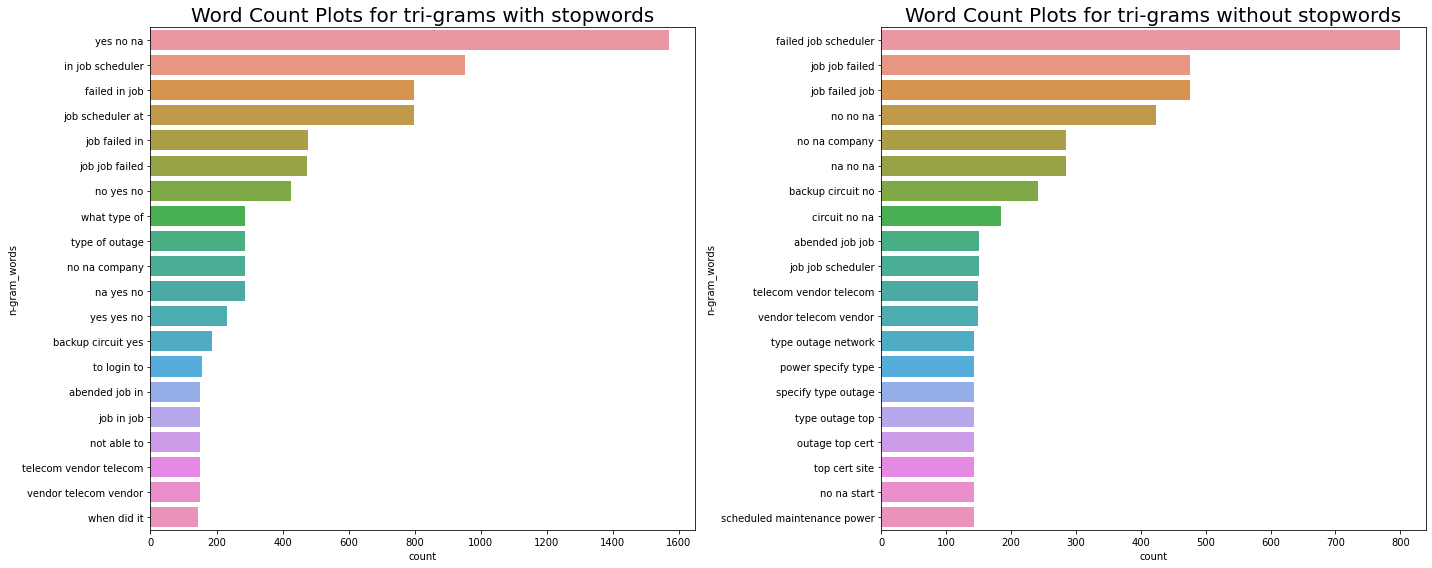

In [76]:
plt.figure(figsize=(20, 8))
#plt.suptitle('Word Count Plots for uni-grams',fontsize=20)
plt.subplot(1, 2, 1)
plt.title('Word Count Plots for tri-grams with stopwords',fontsize=20)
word_count_plot(trigram_df['count'],trigram_df['n-gram_words'], 30, 'asc')
plt.subplot(1, 2, 2)
plt.title('Word Count Plots for tri-grams without stopwords',fontsize=20)
word_count_plot(trigram_df_wo_stopwords['count'],trigram_df_wo_stopwords['n-gram_words'], 30, 'asc')
plt.tight_layout()

## **3. Pre-Processing**

1. Load document from directory
2. Null check on features
3. Cleansing the data as explained in EDA
4. Save back to directory


In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
def load_doc(filename):
  return pd.read_excel(filename, lines=True)

In [0]:
#method to convert text to lowercase
def to_lower (text):
  return text.lower()

#remove some header and footers in the descriptionn
import re
def remove_email(text):
  re_mail = re.compile('\S+@+\S+.?')
  data = [re_mail.sub(' ', word) for word in text.split()]
  return ' '.join(data)

def remove_underscore(text):
    text = text.replace('_',' ')
    text = text.replace("'",'')
    return text

 #replace punctutions with white space
def remove_punctuation(text):
    return text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))

#strip more than 1 leading or trailing white spaces
def strip_addl_whitespace(text):
    return " ".join([word for word in text.split() if word.strip()])

# remove any numbers in the dataset
def remove_non_alpha(text):
  return " ".join([word for word in text.split(" ") if word.isalpha()])

#method to exclude the stopwords from the corpura and also generate exclude word cout
from collections import Counter
from collections import OrderedDict

removed_words=[]
def remove_stopwords(text, stopwords):
  global removed_words
  #global removed_words_counter 
  global removed_words_df
  data = []
  for word in text.split():
    if not word in stopwords:
      data.append(word)
    else:
      removed_words.append(word)
  removed_words_counter = Counter(removed_words)
  removed_words_counter = OrderedDict(sorted(removed_words_counter.items(), key = lambda x: x[1], reverse=True))
  removed_words_df = pd.DataFrame(removed_words_counter.items(),columns=['words','count'])
  return ' '.join(data)

        

In [0]:
def clean_text(text, exclusionTagList, stop_words=None):
  data = remove_line_break(text)
  for excl_txt in exclusionTagList:
    data = remove_exclusion_text(data, excl_txt, '\n')
  data = to_lower(data)
  data = remove_email(data)
  data = remove_underscore(data)
  data = remove_punctuation(data)
  data = strip_addl_whitespace(data)
  data = remove_non_alpha(data)
  data = remove_stopwords(data, stop_words)
  return data

In [0]:
def encode_target(target):
  le = LabelEncoder()
  return le.fit_transform(target), le

def decode_prediction(pred, encoder):
  return encoder.inverse_transform(pred) 

In [0]:
import os
def save_doc(df, dir, filename):
  if not os.path.isdir(dir):
    os.mkdir(dir)
  df.to_csv(dir+filename, index = False, header=True)

In [0]:
def generate_stopwords(new_stopwords, remove_stopwords):
  stop_words = nltk.corpus.stopwords.words('english')
  #to add addl stop words to the nltk list
  stop_words.extend(new_stopwords)
  #remove non stopwords from NLTK stopwords list
  stop_words = [word for word in stop_words if word not in remove_stopwords]
  return stop_words

In [0]:
def pre_process_pipeline(srcFile, features=[], target=[], stop_words=[]):
  data_df = load_doc(srcFile)
  data_df.columns = [c.replace(' ', '_') for c in data_df.columns]
  data_df.columns = [c.lower() for c in data_df.columns]
  columns_to_be_droped = [c for c in list(data_df.columns) if not c in (features + target)]
  print('columns_to_be_droped : ', columns_to_be_droped)
  data_df = data_df.drop(columns_to_be_droped, axis=1)
  data_df['combined_desc'] = data_df['short_description'] + ' ' + data_df['description']
  data_df.description.fillna(data_df.short_description, inplace=True)
  data_df = data_df[['short_description','description','combined_desc','assignment_group']]
  features.append('combined_desc') 

  for column in features:
    print('pre-processing column : ',column)
    data_df[column] = data_df[column].apply(lambda text : clean_text(text, exclusion_text_tags, stop_words))
  
  #le = LabelEncoder()
  #for t in target:
    #data_df[t] = le.fit_transform(data_df[t])
  #return data_df, le
  return data_df

In [0]:
features=['short_description','description']
target= ['assignment_group']
PROJECT_DIR = "/content/gdrive/My Drive/Colab Notebooks/"
DATA_FILE_NAME = 'Input.xlsx'
srcFile = PROJECT_DIR+DATA_FILE_NAME
CLEANSED_FILE_DIR = 'Data/processed/'

addl_stopwords = ['yes', 'please', 'hello', 'name','yes','best','kind']
not_stopwords = ['not', 'no', 'nor']
stop_words = generate_stopwords(addl_stopwords, not_stopwords)

In [86]:
cleansed_df = pre_process_pipeline(srcFile, features, target, stop_words)

columns_to_be_droped :  ['caller']
pre-processing column :  short_description
pre-processing column :  description
pre-processing column :  combined_desc


In [0]:
save_doc(cleansed_df, PROJECT_DIR, 'cleansed.csv')
save_doc(removed_words_df, PROJECT_DIR, 'removed_words.csv')

In [88]:
cleansed_df

,short_description,description,combined_desc,assignment_group
0,login issue,verified user details employee manager checked user ad reset password advised user login check caller confirmed able login issue resolved,login issue verified user details employee manager checked user ad reset password advised user login check caller confirmed able login issue resolved,GRP_0
1,outlook,team meetings skype meetings etc not appearing outlook calendar somebody advise correct,outlook team meetings skype meetings etc not appearing outlook calendar somebody advise correct,GRP_0
2,cant log vpn,hi cannot log vpn,cant log vpn hi cannot log vpn,GRP_0
3,unable access hr tool page,unable access hr tool page,unable access hr tool page unable access hr tool page,GRP_0
4,skype error,skype error,skype error skype error,GRP_0
...,...,...,...,...
8495,emails not coming zz mail,good afternoon not receiving emails sent zz mail advise,emails not coming zz mail good afternoon not receiving emails sent zz mail advise,GRP_29
8496,telephony software issue,telephony software issue,telephony software issue telephony software issue,GRP_0
8497,windows password reset tifpdchb pedxruyf,windows password reset tifpdchb pedxruyf,windows password reset tifpdchb pedxruyf windows password reset tifpdchb pedxruyf,GRP_0
8498,machine funcionando,unable access machine utilities finish drawers adjustment settings no network,machine funcionando unable access machine utilities finish drawers adjustment settings no network,GRP_62


In [89]:
cleansed_df.shape

(8500, 4)

In [0]:
labelencoder = LabelEncoder()
cleansed_df['assignment_group'] = labelencoder.fit_transform(cleansed_df['assignment_group'])

In [91]:
cleansed_df

,short_description,description,combined_desc,assignment_group
0,login issue,verified user details employee manager checked user ad reset password advised user login check caller confirmed able login issue resolved,login issue verified user details employee manager checked user ad reset password advised user login check caller confirmed able login issue resolved,0
1,outlook,team meetings skype meetings etc not appearing outlook calendar somebody advise correct,outlook team meetings skype meetings etc not appearing outlook calendar somebody advise correct,0
2,cant log vpn,hi cannot log vpn,cant log vpn hi cannot log vpn,0
3,unable access hr tool page,unable access hr tool page,unable access hr tool page unable access hr tool page,0
4,skype error,skype error,skype error skype error,0
...,...,...,...,...
8495,emails not coming zz mail,good afternoon not receiving emails sent zz mail advise,emails not coming zz mail good afternoon not receiving emails sent zz mail advise,22
8496,telephony software issue,telephony software issue,telephony software issue telephony software issue,0
8497,windows password reset tifpdchb pedxruyf,windows password reset tifpdchb pedxruyf,windows password reset tifpdchb pedxruyf windows password reset tifpdchb pedxruyf,0
8498,machine funcionando,unable access machine utilities finish drawers adjustment settings no network,machine funcionando unable access machine utilities finish drawers adjustment settings no network,59


In [0]:
cleansed_word2vec_df = cleansed_df

In [93]:
cleansed_word2vec_df

,short_description,description,combined_desc,assignment_group
0,login issue,verified user details employee manager checked user ad reset password advised user login check caller confirmed able login issue resolved,login issue verified user details employee manager checked user ad reset password advised user login check caller confirmed able login issue resolved,0
1,outlook,team meetings skype meetings etc not appearing outlook calendar somebody advise correct,outlook team meetings skype meetings etc not appearing outlook calendar somebody advise correct,0
2,cant log vpn,hi cannot log vpn,cant log vpn hi cannot log vpn,0
3,unable access hr tool page,unable access hr tool page,unable access hr tool page unable access hr tool page,0
4,skype error,skype error,skype error skype error,0
...,...,...,...,...
8495,emails not coming zz mail,good afternoon not receiving emails sent zz mail advise,emails not coming zz mail good afternoon not receiving emails sent zz mail advise,22
8496,telephony software issue,telephony software issue,telephony software issue telephony software issue,0
8497,windows password reset tifpdchb pedxruyf,windows password reset tifpdchb pedxruyf,windows password reset tifpdchb pedxruyf windows password reset tifpdchb pedxruyf,0
8498,machine funcionando,unable access machine utilities finish drawers adjustment settings no network,machine funcionando unable access machine utilities finish drawers adjustment settings no network,59


In [0]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(cleansed_df['description'], cleansed_df['assignment_group'], test_size=0.33, shuffle= True)

In [95]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#Tokenize the sentences
tokenizer = Tokenizer()

#preparing vocabulary
tokenizer.fit_on_texts(list(x_train))

#converting text into integer sequences
x_tr_seq  = tokenizer.texts_to_sequences(x_train) 
x_val_seq = tokenizer.texts_to_sequences(x_valid)

#padding to prepare sequences of same length
x_tr_seq  = pad_sequences(x_tr_seq, maxlen=1000)
x_val_seq = pad_sequences(x_val_seq, maxlen=1000)


Using TensorFlow backend.


**Pretrained Glove embeddings with 300d**

In [146]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('../content/gdrive/My Drive/Colab Notebooks/glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [147]:
size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

7367


In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [0]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import *

In [150]:


model=Sequential()

#embedding layer
model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=1000,trainable=False)) 

#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(128,activation='relu'))  
model.add(Dense(74,activation='softmax'))  

#Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=["acc"]) 

#Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

#Print summary of model
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 300)         2210100   
_________________________________________________________________
lstm_4 (LSTM)                (None, 1000, 128)         219648    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 74)                9546      
Total params: 2,455,806
Trainable params: 245,706
Non-trainable params: 2,210,100
_________________________________________________________________
None


In [151]:
history = model.fit(np.array(x_tr_seq),np.array(y_train),batch_size=128,epochs=5,validation_data=(np.array(x_val_seq),np.array(y_valid)),verbose=1,callbacks=[es,mc])

Train on 5695 samples, validate on 2805 samples
Epoch 1/5
5695/5695 [==============================] - 263s 46ms/step - loss: 3.0246 - acc: 0.4393 - val_loss: 2.4400 - val_acc: 0.5148

Epoch 00001: val_acc improved from -inf to 0.51480, saving model to best_model.h5
Epoch 2/5
5695/5695 [==============================] - 261s 46ms/step - loss: 2.3191 - acc: 0.5226 - val_loss: 2.1602 - val_acc: 0.5380

Epoch 00002: val_acc improved from 0.51480 to 0.53797, saving model to best_model.h5
Epoch 3/5
5695/5695 [==============================] - 261s 46ms/step - loss: 2.1268 - acc: 0.5349 - val_loss: 2.0749 - val_acc: 0.5408

Epoch 00003: val_acc improved from 0.53797 to 0.54082, saving model to best_model.h5
Epoch 4/5
5695/5695 [==============================] - 263s 46ms/step - loss: 2.0220 - acc: 0.5463 - val_loss: 1.9630 - val_acc: 0.5683

Epoch 00004: val_acc improved from 0.54082 to 0.56827, saving model to best_model.h5
Epoch 5/5
5695/5695 [==============================] - 263s 46ms/st

In [152]:
#loading best model
from keras.models import load_model
model = load_model('best_model.h5')

#evaluation 
_,val_acc = model.evaluate(x_val_seq,y_valid, batch_size=128)
print(val_acc)

2805/2805 [==============================] - 35s 13ms/step
0.5721924901008606


In [103]:
pip install --upgrade gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.2)


**Word2Vec pretrained embedding with 200D**

In [0]:
from sklearn.model_selection import train_test_split

# Split the data
x_train_vec, x_valid_vec, y_train_vec, y_valid_vec = train_test_split(cleansed_df['description'], cleansed_df['assignment_group'], test_size=0.33, shuffle= True)

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#Tokenize the sentences
tokenizer = Tokenizer()

#preparing vocabulary
tokenizer.fit_on_texts(list(x_train_vec))

#converting text into integer sequences
x_tr_seq_vec  = tokenizer.texts_to_sequences(x_train_vec) 
x_val_seq_vec = tokenizer.texts_to_sequences(x_valid_vec)

#padding to prepare sequences of same length
x_tr_seq_vec  = pad_sequences(x_tr_seq_vec, maxlen=1000)
x_val_seq_vec = pad_sequences(x_val_seq_vec, maxlen=1000)

In [106]:
size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

7367


In [0]:
from gensim.models.keyedvectors import KeyedVectors
PROJECT_DIR = "/content/gdrive/My Drive/Colab Notebooks/"
EMBEDDING_FILE = 'SO_vectors_200.bin'
EmbeddingFile = PROJECT_DIR+EMBEDDING_FILE
word2vec = KeyedVectors.load_word2vec_format(EmbeddingFile, binary=True)
MAX_SEQUENCE_LENGTH = 30
MAX_NB_WORDS = 200000


In [0]:
# create a weight matrix for words in training docs
EMBEDDING_DIM = 200
embedding_matrix_word2vec = np.zeros((size_of_vocabulary, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if word in word2vec.vocab:
        embedding_matrix_word2vec[i] = word2vec.word_vec(word)    


In [156]:
model=Sequential()

#embedding layer
model.add(Embedding(size_of_vocabulary,200,weights=[embedding_matrix_word2vec],input_length=1000,trainable=False)) 

#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(128,activation='relu'))  
model.add(Dense(74,activation='softmax'))  

#Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=["acc"]) 

#Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

#Print summary of model
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1000, 200)         1473400   
_________________________________________________________________
lstm_5 (LSTM)                (None, 1000, 128)         168448    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 74)                9546      
Total params: 1,667,906
Trainable params: 194,506
Non-trainable params: 1,473,400
_________________________________________________________________
None


In [157]:
model.fit(np.array(x_tr_seq_vec),np.array(y_train_vec),batch_size=128,epochs=5,validation_data=(np.array(x_val_seq_vec),np.array(y_valid_vec)),verbose=1,callbacks=[es,mc])

Train on 5695 samples, validate on 2805 samples
Epoch 1/5
5695/5695 [==============================] - 243s 43ms/step - loss: 2.9175 - acc: 0.4609 - val_loss: 2.2160 - val_acc: 0.5344

Epoch 00001: val_acc improved from -inf to 0.53440, saving model to best_model.h5
Epoch 2/5
5695/5695 [==============================] - 240s 42ms/step - loss: 2.1077 - acc: 0.5349 - val_loss: 1.9817 - val_acc: 0.5497

Epoch 00002: val_acc improved from 0.53440 to 0.54973, saving model to best_model.h5
Epoch 3/5
5695/5695 [==============================] - 239s 42ms/step - loss: 1.9206 - acc: 0.5521 - val_loss: 1.8709 - val_acc: 0.5729

Epoch 00003: val_acc improved from 0.54973 to 0.57291, saving model to best_model.h5
Epoch 4/5
5695/5695 [==============================] - 239s 42ms/step - loss: 1.7931 - acc: 0.5712 - val_loss: 1.7868 - val_acc: 0.5847

Epoch 00004: val_acc improved from 0.57291 to 0.58467, saving model to best_model.h5
Epoch 5/5
5695/5695 [==============================] - 238s 42ms/st

In [111]:
#loading best model
from keras.models import load_model
model = load_model('best_model.h5')

#evaluation 
_,val_acc = model.evaluate(x_val_seq_vec,y_valid_vec, batch_size=128)
print(val_acc)

2805/2805 [==============================] - 32s 11ms/step
0.5554367303848267


**FASTTEXT pre trained embedding**

In [0]:
from sklearn.model_selection import train_test_split

# Split the data
x_train_fast, x_valid_fast, y_train_fast, y_valid_fast = train_test_split(cleansed_df['description'], cleansed_df['assignment_group'], test_size=0.33, shuffle= True)

In [254]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#Tokenize the sentences
tokenizer = Tokenizer()

#preparing vocabulary
tokenizer.fit_on_texts(list(x_train_fast))

#converting text into integer sequences
x_tr_seq_fast  = tokenizer.texts_to_sequences(x_train_fast) 
x_val_seq_fast = tokenizer.texts_to_sequences(x_valid_fast)

#padding to prepare sequences of same length
x_tr_seq_fast  = pad_sequences(x_tr_seq_fast, maxlen=1000)
x_val_seq_fast = pad_sequences(x_val_seq_fast, maxlen=1000)

size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)


7364


In [0]:
max_features = 200000 #17780 #using all unique words
embedding_dim = 300
num_classes = 74
batch_size = 128

embedding_path = "/content/gdrive/My Drive/Colab Notebooks/wiki-news-300d-1M.vec"

def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path))

word_index = tokenizer.word_index
nb_words = len(word_index)
embedding_matrix_fast = np.zeros((nb_words + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix_fast[i] = embedding_vector

In [256]:
model=Sequential()

#embedding layer
model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix_fast],input_length=1000,trainable=False)) 

#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(128,activation='relu'))  
model.add(Dense(74,activation='softmax'))  

#Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=["acc"]) 

#Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

#Print summary of model
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1000, 300)         2209200   
_________________________________________________________________
lstm_10 (LSTM)               (None, 1000, 128)         219648    
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_16 (Dense)             (None, 74)                9546      
Total params: 2,454,906
Trainable params: 245,706
Non-trainable params: 2,209,200
_________________________________________________________________
None


In [257]:
model.fit(np.array(x_tr_seq_fast),np.array(y_train_fast),batch_size=128,epochs=5,validation_data=(np.array(x_val_seq_fast),np.array(y_valid_fast)),verbose=1,callbacks=[es,mc])

Train on 5695 samples, validate on 2805 samples
Epoch 1/5
5695/5695 [==============================] - 263s 46ms/step - loss: 2.9795 - acc: 0.4572 - val_loss: 2.5273 - val_acc: 0.4645

Epoch 00001: val_acc improved from -inf to 0.46453, saving model to best_model.h5
Epoch 2/5
5695/5695 [==============================] - 261s 46ms/step - loss: 2.4313 - acc: 0.4694 - val_loss: 2.3572 - val_acc: 0.4645

Epoch 00002: val_acc did not improve from 0.46453
Epoch 3/5
5695/5695 [==============================] - 261s 46ms/step - loss: 2.2332 - acc: 0.5294 - val_loss: 2.1784 - val_acc: 0.5330

Epoch 00003: val_acc improved from 0.46453 to 0.53298, saving model to best_model.h5
Epoch 4/5
5695/5695 [==============================] - 260s 46ms/step - loss: 2.1067 - acc: 0.5385 - val_loss: 2.1255 - val_acc: 0.5330

Epoch 00004: val_acc did not improve from 0.53298
Epoch 5/5
5695/5695 [==============================] - 260s 46ms/step - loss: 2.0267 - acc: 0.5410 - val_loss: 2.0278 - val_acc: 0.5422



In [162]:
#loading best model
from keras.models import load_model
model = load_model('best_model.h5')

#evaluation 
_,val_acc = model.evaluate(x_val_seq_vec,y_valid_vec, batch_size=128)
print(val_acc)

2805/2805 [==============================] - 35s 12ms/step
0.5611408352851868


**BERT pre trained embedding**

In [181]:
# Split the data
x_train_bert, x_valid_bert, y_train_bert, y_valid_bert = train_test_split(cleansed_df['description'], cleansed_df['assignment_group'], test_size=0.33, shuffle= True)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#Tokenize the sentences
tokenizer = Tokenizer()

#preparing vocabulary
tokenizer.fit_on_texts(list(x_train_bert))

#converting text into integer sequences
x_tr_seq_bert  = tokenizer.texts_to_sequences(x_train_bert) 
x_val_seq_bert = tokenizer.texts_to_sequences(x_valid_bert)

#padding to prepare sequences of same length
x_tr_seq_bert  = pad_sequences(x_tr_seq_bert, maxlen=1000)
x_val_seq_bert = pad_sequences(x_val_seq_bert, maxlen=1000)

size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

7456


In [172]:
!pip install bert-for-tf2

#pip install bert-embedding
# If you want to run on GPU machine, please install `mxnet-cu92`.
#pip install mxnet-cu92

     |████████████████████████████████| 40kB 2.3MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.4-cp36-none-any.whl size=30114 sha256=571d12f9daca61410ab2fa86125321876dab40f23cd553459a8043236bc5f7bc
  Stored in directory: /root/.cache/pip/wheels/cf/3f/4d/79d7735015a5f523648df90d871ce8e89a7df8185f7703eeab
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=43df6866e31da80c168063afb818abe1f879c66fb866d15df9ff3f96fab4003c
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.0-cp36-none-any.whl size=15999 sha256=aa8472dde42d8e6879473e694bda309a648cc43ebf79ddefb9bb02e4a7882567
  Stored in directory: /root/.cache/pip/wheels/88/41/05/1a9955d1d01575bbd58aab76e22f8c7eeabba905d551576f43
Successfully built bert-for-tf2 py-params params-flow


In [0]:
%tensorflow_version 2.x
 
import tensorflow as tf
import tensorflow_hub as hub
import bert
from tensorflow.keras.models import  Model
from tqdm import tqdm
import numpy as np
from collections import namedtuple

In [0]:
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True)


In [0]:
MAX_SEQ_LEN=128
input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                    name="segment_ids")

In [0]:
def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))
 
def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

In [0]:
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [0]:
FullTokenizer=bert.bert_tokenization.FullTokenizer
 
vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()
 
do_lower_case=bert_layer.resolved_object.do_lower_case.numpy()
 
tokenizer=FullTokenizer(vocab_file,do_lower_case)
 
def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [0]:
def create_single_input(sentence,MAX_LEN):
  
  stokens = tokenizer.tokenize(sentence)
  
  stokens = stokens[:MAX_LEN]
  
  stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
  ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
  masks = get_masks(stokens, MAX_SEQ_LEN)
  segments = get_segments(stokens, MAX_SEQ_LEN)
 
  return ids,masks,segments
 
def create_input_array(sentences):
 
  input_ids, input_masks, input_segments = [], [], []
 
  for sentence in tqdm(sentences,position=0, leave=True):
  
    ids,masks,segments=create_single_input(sentence,MAX_SEQ_LEN-2)
 
    input_ids.append(ids)
    input_masks.append(masks)
    input_segments.append(segments)
 
  return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)]

In [202]:
x = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
x = tf.keras.layers.Dropout(0.2)(x)
out = tf.keras.layers.Dense(1, activation="sigmoid", name="dense_output")(x)
 
model = tf.keras.models.Model(
      inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
 
model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
#Print summary of model
print(model.summary())


 

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [203]:
model.fit(np.array(x_tr_seq_bert),np.array(y_train_bert),validation_data=(np.array(x_val_seq_bert),np.array(y_valid_bert)),epochs=5,batch_size=128,shuffle=True)

#model.fit(np.array(x_tr_seq_bert),np.array(y_train_bert),batch_size=128,epochs=5,validation_data=(np.array(x_val_seq_bert),np.array(y_valid_bert)),verbose=1,callbacks=[es,mc])

Epoch 1/5


AssertionError: ignored

**ELMO pre trained embedding**

In [0]:
import tensorflow_hub as hub
import tensorflow as tf

In [0]:
from sklearn.model_selection import train_test_split
# Split the data
x_train_elmo, x_valid_elmo, y_train_elmo, y_valid_elmo = train_test_split(cleansed_df['description'], cleansed_df['assignment_group'], test_size=0.33, shuffle= True)

In [0]:
 elmo_model = hub.load("https://tfhub.dev/google/Wiki-words-250/2")

In [0]:
# Statement that we used on the top
sample_statement = ["Jack while talking over the cell phone entered the prison cell to extract blood cell samples of Jill and made an entry in the excel cell about the blood sample collection."]
# Extract ELMo features 
embeddings = elmo_model(sample_statement)

#embeddings = elmo_model(embedding_matrix, signature="default", as_dict=True)["elmo_model"]

In [0]:
def ELMoEmbedding(input_text):
    return elmo_model(tf.reshape(tf.cast(input_text, tf.string), [-1]), signature="default", as_dict=True)["elmo_model"]

In [0]:
def build_model():
    input_layer = Input(shape=(1,), dtype="string", name="Input_layer")
    embedding_layer = Lambda(ELMoEmbedding, output_shape=(1024, ))
    BiLSTM = Bidirectional(layers.LSTM(1024, return_sequences= False, recurrent_dropout=0.2, dropout=0.2), name="BiLSTM")(embedding_layer)
    Dense_layer_1 = Dense(8336, activation='relu')(BiLSTM)
    Dropout_layer_1 = Dropout(0.5)(Dense_layer_1)
    Dense_layer_2 = Dense(4168, activation='relu')(Dropout_layer_1)
    Dropout_layer_2 = Dropout(0.5)(Dense_layer_2)
    output_layer = Dense(74, activation='softmax')(Dropout_layer_2)
    model = Model(inputs=[input_layer], outputs=output_layer, name="BiLSTM with ELMo Embeddings")
    model.compile(loss='sparse_categorical_crossentropyy',optimizer='adam',metrics=['accuracy'])
#    model.summary()
    return model

In [252]:
model.summary()
#elmo_BiDirectional_model = build_model()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [250]:
model.fit(np.array(x_train_elmo),np.array(y_train_elmo),batch_size=128,epochs=5,validation_data=(np.array(x_valid_elmo),np.array(y_valid_elmo)),verbose=1)

Epoch 1/5


AssertionError: ignored